# Data Science Analyze and Present A/B Test Results

X company recently introduced a new bidding type, “average bidding”, as an alternative to its exisiting bidding
type, called “maximum bidding”. One of our clients, X.com, has decided to test this new feature
and wants to conduct an A/B test to understand if average bidding brings more conversions than maximum
bidding.

In this A/B test, X.com randomly splits its audience into two equally sized groups, e.g. the test
and the control group. A X company ad campaign with “maximum bidding” is served to “control group” and
another campaign with “average bidding” is served to the “test group”.

The A/B test has run for 1 month and X.com now expects you to analyze and present the results
of this A/B test.



##### You should answer the following questions in this notebook

1. How would you define the hypothesis of this A/B test?
2. Can we conclude statistically significant results?
3. Which statistical test did you use, and why?
4. Based on your answer to Question 2, what would be your recommendation to client?


##### Hints:

1. The customer journey for this campaign is:
    1. User sees an ad (Impression)
    2. User clicks on the website link on the ad (Website Click)
    3. User makes a search on the website (Search)
    4. User views details of a product (View Content)
    5. User adds the product to the cart (Add to Cart)
    6. User purchases the product (Purchase)
2. Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.
3. If you see trends, anomalies or other patterns, discuss these in your notebool.
4. You can make assumptions if needed.


## 1. Import libraries

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skewtest
from scipy.stats import median_test
from scipy.stats import shapiro
import pylab
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import levene
from statsmodels.stats.proportion import proportions_ztest
from sklearn.impute import KNNImputer

pd.set_option("display.max_columns",None);
pd.set_option("display.max_rows",None);

## 2. Functions

In [ ]:
def read_data() :
    """
      Reads and loads control and test group data from an CSV file
    - **Control group** (Maximum Bidding): Existing campaign data.
    - **Test group** (Average Bidding): Data from the new bidding strategy.
    The function removes rows with NaN values that originated from notes in the Excel file for the control group.
    """
    #Maximum Bidding(Existing)
    control = pd.read_csv("control_group.csv",sep=";")
    #Average Bidding(New)
    test = pd.read_csv("test_group.csv",sep=";")

    return control, test

def get_catvar(df) :
    """
    Identifies and extracts categorical variables from a DataFrame.
    - Returns the original DataFrame, a DataFrame of only categorical variables, and the names of the categorical columns.
    """
    cat_col = [col for col in df.columns if ( (df[col].dtype == 'object') | (df[col].dtype == 'bool'))]
    kat_df = pd.DataFrame(df[cat_col], index = df[cat_col].index)
    return df, kat_df, cat_col

def get_numvar(cat_col,df):
    """
    Identifies and extracts numerical variables from a DataFrame, excluding those specified as categorical.
    - Returns the original DataFrame, a DataFrame of only numerical variables, and the names of the numerical columns.
    """
    num_col = [c for c in df.columns if c not in cat_col]
    num_df = pd.DataFrame(df[num_col], index = df[num_col].index)
    return df, num_df, num_col

def fill_NaNValue(num_control) :
    """
    Implements K-Nearest Neighbors Imputation to fill in missing values in numerical columns of the control group.
    - Returns a DataFrame with missing values filled.
    """
    cols = num_control.columns
    imputer = KNNImputer(n_neighbors=4)
    num_control = imputer.fit_transform(num_control)
    num_control=pd.DataFrame(num_control,columns=cols)
    return num_control

def convert_datatype(control):
    """
      Converts specified columns in the control group DataFrame to integer data types.
    - This is important for ensuring data consistency and correctness in calculations.
    """
    control = control.astype({'# of Impressions' : 'int64',
                        'Reach': 'int64',
                        '# of Website Clicks' : 'int64',
                        '# of Searches': 'int64',
                        '# of View Content': 'int64',
                        '# of Add to Cart': 'int64',
                        '# of Purchase' : 'int64'})
    return control

def outliers(control, test):
    """
    Detects and handles outliers in the test group data using Local Outlier Factor (LOF).
    - Prints scores of the detected outliers and modifies extreme outlier values based on a specified threshold.
    """
    clf= LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
    clf.fit_predict(test.iloc[:,2:])[0:10]

    test_scores=clf.negative_outlier_factor_
    print("Test Score: " , np.sort(test_scores)[0:20])
    sns.boxplot(test_scores);

    threshold=np.sort(test_scores)[4]
    print("Threshold score: ", threshold)

    test.loc[test_scores < -1.50].index
    test.loc[test_scores == threshold]

    test.iloc[0,2:]=[2742.245945,79574,57168,3086,1263,1098,226,277]
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,3:5]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,5:6]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,6:]));
    plt.xticks(rotation=90)

    
def feature_engineering(control, test):
    """
    Creates new features for both control and test groups to aid in analysis:
    - Website Click Through Rate: The percentage of clicks per number of impressions.
    - Number of Action: Sum of various engagement metrics like impressions, clicks, etc.
    - Cost per Action: The spend divided by the number of actions.
    - Conversion Rate: The number of actions divided by the number of clicks, expressed as a percentage.
    """
    control["Website Click Through Rate"] = control["# of Website Clicks"] / control["# of Impressions"] * 100
    test["Website Click Through Rate"] = test["# of Website Clicks"] / test["# of Impressions"] * 100

    control["Number of Action"] = control["# of Impressions"] + control["# of Website Clicks"] + control["# of Searches"] + control["# of View Content"] + control["# of Add to Cart"] + control["# of Purchase"]
    test["Number of Action"] = test["# of Impressions"] + test["# of Website Clicks"] + test["# of Searches"] + test["# of View Content"] + test["# of Add to Cart"] + test["# of Purchase"]

    control["Cost per Action"] = control["Spend [USD]"] / control["Number of Action"]
    test["Cost per Action"] = test["Spend [USD]"] / test["Number of Action"]

    control["Conversion Rate"] = control["Number of Action"] / control["# of Website Clicks"] * 100
    test["Conversion Rate"] = test["Number of Action"] / test["# of Website Clicks"] * 100

    return control, test

def data_prepare_for_visualization(control,test):
    """
    Prepares control and test group data for visualization by extracting specific metrics and labeling them for group comparison.
    - Returns a consolidated DataFrame of both groups for visualization purposes.
    """
    control_nop = pd.DataFrame(control["# of Purchase"])
    test_nop = pd.DataFrame(test["# of Purchase"])

    control_wctr= pd.DataFrame(control["Website Click Through Rate"])
    test_wctr= pd.DataFrame(test["Website Click Through Rate"])

    control_cpa= pd.DataFrame(control["Cost per Action"])
    test_cpa= pd.DataFrame(test["Cost per Action"])

    control_cr= pd.DataFrame(control["Conversion Rate"])
    test_cr= pd.DataFrame(test["Conversion Rate"])

    Group_A = pd.concat([control_nop, control_wctr, control_cpa, control_cr], axis = 1)
    Group_A["Group"] = "A (MaximumBidding)"

    Group_B = pd.concat([test_nop, test_wctr, test_cpa, test_cr], axis = 1)
    Group_B["Group"] = "B (AverageBidding)"

    #Tum veri
    AB = pd.concat([Group_A, Group_B])
    AB
    return AB, control_nop, test_nop

def data_prepare_for_hypothesis_testing(control_nop, test_nop):
    """
    Prepares control and test group data for hypothesis testing by combining "# of Purchase" data into a single DataFrame.
    - The resulting DataFrame is structured for direct comparison between groups.
    """
    controlB = pd.concat([control_nop, test_nop], axis = 1)
    controlB.columns = ["A","B"]
    return controlB

def num_boxplot(fig, axarr, dimension, cols, hue):
    """
    A helper function for plotting boxplots of numerical data, categorized by the experiment group.
    - It iterates over specified dimensions and columns to generate boxplots for visual analysis.
    """
    for i in dimension :
        for j in dimension :
            for c in cols :
                sns.boxplot(y=c, x = hue, hue = hue, data = AB, ax=axarr[i][j])
                cols.remove(c)
                break

def show_boxplot(nrows, ncols, boyut, cols, figsize):
    """
    Generates boxplots for the specified columns and groups, utilizing `num_boxplot`.
    - Allows specification of the number of rows and columns in the figure, and figure size.
    """
    fig, axarr = plt.subplots(nrows, ncols, figsize=figsize)
    num_boxplot(fig, axarr, boyut, cols, "Group")


def checkReject(p_value, alpha = 0.05):
    """
    Checks whether the p-value from hypothesis testing is significant enough to reject the null hypothesis, given an alpha level (default 0.05).
    - Prints the outcome of the hypothesis test in the context of rejecting or not rejecting the null hypothesis.
    """
    if p_value < alpha :
        print(f'{p_value} < alpha(0.05) so >>> H0 REJECTED')

    elif p_value > alpha :
        print(f'{p_value} > alpha(0.05) so >>> H0 CAN\'T BE REJECTED')

## 3. Data Preparation

In [85]:
control, test = read_data()

#### Control dataset

In [86]:
# print what is control
control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
#check for null values in control

control.isnull().sum()

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64

No missing values were detected in a control dataset.

In [88]:
#segment the control DataFrame into two separate DataFrames based on data type: one for categorical variables (kat_control) and one for numerical variables (num_control).

_,kat_control,cat_col_control = get_catvar(control)
_,num_control,num_col_control = get_numvar(cat_col_control,control)


In [89]:
#produces lists of column names for both categories for further use or reference.
_,_,cat_col_control = get_catvar(control)
print(cat_col_control)


['Campaign Name', 'Date']


In [90]:
# df with only categorical columns
kat_control.head()

,Campaign Name,Date
0,Control Campaign,1.08.2019
1,Control Campaign,2.08.2019
2,Control Campaign,3.08.2019
3,Control Campaign,4.08.2019
4,Control Campaign,5.08.2019


In [91]:
# df with only numerical columns
num_control.head()

,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
#  Fill the control dataframe values NaN value with KNNImputer.
num_control_filled_na = fill_NaNValue(num_control)
num_control_filled_na.head()


,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,2280.0,82702.00,56930.0,7016.0,2290.00,2159.00,1819.0,618.0
1,1757.0,121040.00,102513.0,8110.0,2033.00,1841.00,1219.0,511.0
2,2343.0,131711.00,110862.0,6508.0,1737.00,1549.00,1134.0,372.0
3,1940.0,72878.00,61235.0,3065.0,1042.00,982.00,1183.0,340.0
4,1835.0,100217.25,81752.5,5387.5,1910.25,1727.25,1410.0,604.0


In [93]:
# TODO : Combine categorical and numerical variables with the concept.

combined_control = pd.concat([kat_control,num_control_filled_na],axis =1)
combined_control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280.0,82702.00,56930.0,7016.0,2290.00,2159.00,1819.0,618.0
1,Control Campaign,2.08.2019,1757.0,121040.00,102513.0,8110.0,2033.00,1841.00,1219.0,511.0
2,Control Campaign,3.08.2019,2343.0,131711.00,110862.0,6508.0,1737.00,1549.00,1134.0,372.0
3,Control Campaign,4.08.2019,1940.0,72878.00,61235.0,3065.0,1042.00,982.00,1183.0,340.0
4,Control Campaign,5.08.2019,1835.0,100217.25,81752.5,5387.5,1910.25,1727.25,1410.0,604.0


#### Test dataset

In [94]:
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [95]:
 # Check for null values in test

test.isnull().sum()

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       0
Reach                  0
# of Website Clicks    0
# of Searches          0
# of View Content      0
# of Add to Cart       0
# of Purchase          0
dtype: int64

No missing values were detected in a test dataset.

In [96]:
#segment the control DataFrame into two separate DataFrames based on data type: one for categorical variables (kat_control) and one for numerical variables (num_control).

_,kat_test,cat_col_test = get_catvar(test)
_,num_test,num_col_test = get_numvar(cat_col_test,test)

In [97]:
#produces lists of column names for both categories for further use or reference.
_,_,cat_col_test= get_catvar(test)
print(cat_col_test)

['Campaign Name', 'Date']


In [98]:
# df with only categorical columns
kat_test.head()

,Campaign Name,Date
0,Test Campaign,1.08.2019
1,Test Campaign,2.08.2019
2,Test Campaign,3.08.2019
3,Test Campaign,4.08.2019
4,Test Campaign,5.08.2019


In [99]:
# df with only numerical columns
num_test.head()

,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,3008,39550,35820,3038,1946,1069,894,255
1,2542,100719,91236,4657,2359,1548,879,677
2,2365,70263,45198,7885,2572,2367,1268,578
3,2710,78451,25937,4216,2216,1437,566,340
4,2297,114295,95138,5863,2106,858,956,768


In [100]:
#  Fill the control dataframe values NaN value with KNNImputer.

Since we don't have any missing data, there is no need to use KNNImputer.

In [101]:

combined_test = pd.concat([kat_test,num_test],axis =1)
combined_test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


Test Score:  [-1.31554523 -1.2199842  -1.15749682 -1.137457   -1.1319886  -1.10751045
 -1.1065609  -1.06668376 -1.04579889 -1.0250938  -1.0111609  -1.00368407
 -0.99570209 -0.99469353 -0.99436478 -0.99421703 -0.99045285 -0.98968144
 -0.98968005 -0.98568235]
Threshold score:  -1.1319885952353625


/var/folders/zs/lhn3v0dx0v32gt7hm_r0m1zc0000gn/T/ipykernel_32115/1519529228.py:76: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2742.245945' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test.iloc[0,2:]=[2742.245945,79574,57168,3086,1263,1098,226,277]


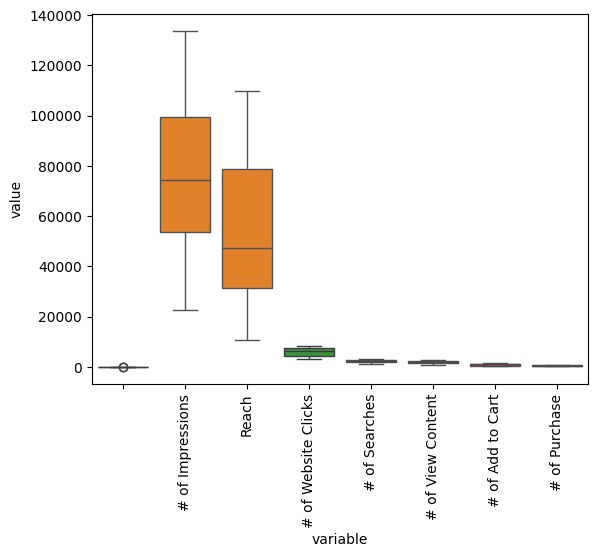

In [102]:
combined_test_ouliers = outliers(control, test)

In [103]:
# Let's do a data type conversion.

control = convert_datatype(combined_control)
test = convert_datatype(combined_test)
print(control.shape)
print(test.shape)

(30, 10)
(30, 10)


In [121]:
# Check your dataframes

print(control.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Campaign Name               30 non-null     object 
 1   Date                        30 non-null     object 
 2   Spend [USD]                 30 non-null     float64
 3   # of Impressions            30 non-null     int64  
 4   Reach                       30 non-null     int64  
 5   # of Website Clicks         30 non-null     int64  
 6   # of Searches               30 non-null     int64  
 7   # of View Content           30 non-null     int64  
 8   # of Add to Cart            30 non-null     int64  
 9   # of Purchase               30 non-null     int64  
 10  Website Click Through Rate  30 non-null     float64
 11  Number of Action            30 non-null     int64  
 12  Cost per Action             30 non-null     float64
 13  Conversion Rate             30 non-nu

In [122]:
# convert column "Spend[USD]" in both datasets to float
for df in (control, test):
    df['Spend [USD]'] = pd.to_numeric(df['Spend [USD]'], errors='coerce').astype('float64')

In [123]:
test.info()
control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Campaign Name               30 non-null     object 
 1   Date                        30 non-null     object 
 2   Spend [USD]                 30 non-null     float64
 3   # of Impressions            30 non-null     int64  
 4   Reach                       30 non-null     int64  
 5   # of Website Clicks         30 non-null     int64  
 6   # of Searches               30 non-null     int64  
 7   # of View Content           30 non-null     int64  
 8   # of Add to Cart            30 non-null     int64  
 9   # of Purchase               30 non-null     int64  
 10  Website Click Through Rate  30 non-null     float64
 11  Number of Action            30 non-null     int64  
 12  Cost per Action             30 non-null     float64
 13  Conversion Rate             30 non-nu

## 4. Preparing Data for Hypothesis Testing (A/B Test)



In [ ]:
#TODO : Apply the feature engineering on control and test, what does the function do exactly ?

control,test = feature_engineering(control, test)
control.head()

#TODO : Prepare and generate features for visualization with the help of a function

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,Website Click Through Rate,Number of Action,Cost per Action,Conversion Rate
0,Control Campaign,1.08.2019,2280.0,82702,56930,7016,2290,2159,1819,618,8.483471,96604,0.023602,1376.909920
1,Control Campaign,2.08.2019,1757.0,121040,102513,8110,2033,1841,1219,511,6.700264,134754,0.013039,1661.578298
2,Control Campaign,3.08.2019,2343.0,131711,110862,6508,1737,1549,1134,372,4.941121,143011,0.016383,2197.464659
3,Control Campaign,4.08.2019,1940.0,72878,61235,3065,1042,982,1183,340,4.205659,79490,0.024406,2593.474715
4,Control Campaign,5.08.2019,1835.0,100217,81752,5387,1910,1727,1410,604,5.375336,111255,0.016494,2065.249675


In [112]:
test.head()


,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,Website Click Through Rate,Number of Action,Cost per Action,Conversion Rate
0,Test Campaign,1.08.2019,3008.0,39550,35820,3038,1946,1069,894,255,7.681416,46752,0.064339,1538.907176
1,Test Campaign,2.08.2019,2542.0,100719,91236,4657,2359,1548,879,677,4.623755,110839,0.022934,2380.051535
2,Test Campaign,3.08.2019,2365.0,70263,45198,7885,2572,2367,1268,578,11.222123,84933,0.027845,1077.146481
3,Test Campaign,4.08.2019,2710.0,78451,25937,4216,2216,1437,566,340,5.374055,87226,0.031069,2068.927894
4,Test Campaign,5.08.2019,2297.0,114295,95138,5863,2106,858,956,768,5.129708,124846,0.018399,2129.387685


In [118]:
AB,control_nop,test_nop = data_prepare_for_visualization(control,test)
print("Combined dataset shape:", AB.shape)
print("Control purchases:\n", control_nop.head())
print("Test purchases:\n", test_nop.head())

Combined dataset shape: (60, 5)
Control purchases:
    # of Purchase
0            618
1            511
2            372
3            340
4            604
Test purchases:
    # of Purchase
0            255
1            677
2            578
3            340
4            768


Let's look at the numbers A and B.

In [119]:
AB["Group"].value_counts()

Group
A (MaximumBidding)    30
B (AverageBidding)    30
Name: count, dtype: int64

### 4.1. Website Click Through Rate (CTR)
Review :
- It is a rate that shows how often the users who saw the ad CLICK the ad.
- Number of Ad Clicks / Number of Ad Displays
- Example: 5 clicks, CTR at 100 impressions = 5%

- ##### Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.

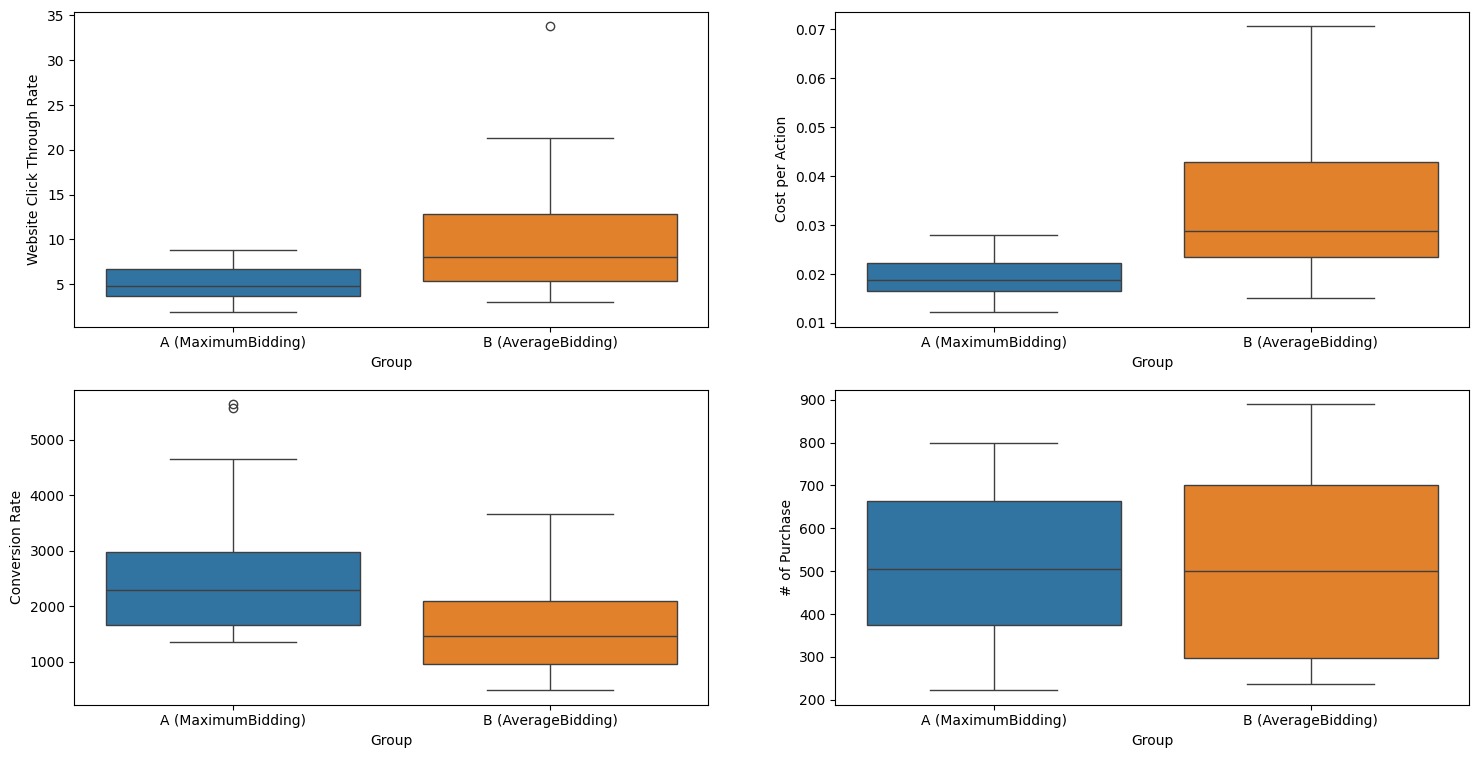

In [120]:
cols = ["Website Click Through Rate","Cost per Action","Conversion Rate","# of Purchase"]
show_boxplot(2,2,[0,1],cols,(18,9))

In [125]:
# create your dataframe for AB test and print the first 3 rows of it.
controlB = data_prepare_for_hypothesis_testing(control_nop, test_nop)
controlB.head()

,A,B
0,618,255
1,511,677
2,372,578
3,340,340
4,604,768


## 5. Two Independent Sample T-Test
### 5.1. Assumption Check
#### 5.1.1. Normality Assumption (shapiro test)

 * **H0**: There is no difference between # of purchases between A(MaximumBidding) and B (AverageBidding)
 * **H1**: There is a difference between # of purchases between A(MaximumBidding) and B (AverageBidding)

In [ ]:
# Aply the normality assumption of the dataframe for A.

 We need to run Shapiro-Wilk test for control group to check if it follows a normal distribution.

-  Null hypothesis (H0): The data comes from a normal distribution.
- Alternative hypothesis : The data does not come from a normal distribution.

In [137]:
#TODO : compute p_value for normality on group A from the df_AB dataframe and round it to three decimal places.

stat_a, p_a = shapiro(controlB['A'])
print(f"Control group p-value:{p_a:.3f}")
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.
hypothesis = checkReject(round(p_a,3),alpha=0.05)


Control group p-value:0.111
0.111 > alpha(0.05) so >>> H0 CAN'T BE REJECTED


Does the HO hypothesis get rejected ? why ?

- After running normality test on control dataset and calculating p-value (0.111) > 0.05, we can conclude that data comes from the normal distribution.
- Thus, We fail to reject the null hypothesis.


In [ ]:
# Aply the normality assumption of the dataframe for B.

-  Null hypothesis (H0): The data comes from a normal distribution.
- Alternative hypothesis : The data does not come from a normal distribution.

In [140]:
#TODO : compute p_value for normality on group B from the df_AB dataframe and round it to three decimal places.

stat_b, p_b = shapiro(controlB['B'])
print(f"Control group p-value:{p_b:.3f}")
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.
hypothesis = checkReject(round(p_b,3),alpha=0.05)

Control group p-value:0.024
0.024 < alpha(0.05) so >>> H0 REJECTED


Does the HO hypothesis get rejected ? why ?


- After running normality test on control dataset and calculating p-value (0.024) > 0.05, we can conclude that data does not follow the normal distribution.
- Thus, we reject the null hypothesis.


### 5.1.2. Variance Homogeneity Assumption
 * **H0** : Variances are homogeneous.
 * **H1** : Variances are not homogeneous.

We want to assess if A and B have equal variances, which is a common assumption for various statistical tests :

In [142]:
# Performs the Levene test for equality of variances on two groups, A and B, from the df_AB dataframe
# compute the p_value of the df_AB dataframe and round it to three decimal places.
#pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

stat, p = levene(controlB['A'], controlB['B'])
print(f"Levene test statistic: {stat:.3f}, p-value: {p:.4f}")
hypothesis = checkReject(round(p,3),alpha=0.05)

Levene test statistic: 1.445, p-value: 0.2343
0.234 > alpha(0.05) so >>> H0 CAN'T BE REJECTED


### 5.1.3. Nonparametric Independent Two-Sample T-Test

- Since the normality of the distribution of the data set in which Average Bidding (Test Group) was measured was rejected, the NonParametric Independent Two-Sample T Test was applied for the Hypothesis Test.

**Hypothesis:**

 * **H0** : When it comes to Maximum Bidding and Average Bidding, there is no statistically significant difference between the purchasing amounts of the two groups. ($\mu_1 = \mu_2$)

 * **H1** : ... there is a difference ($\mu_1 \neq \mu_2$)


Conclude about the variances, are they homogeneous ?

Since p-value (0.234) >0.05, we fail to reject the null hypothesis.Thus, variances are homogeneous.

In [148]:
# Average Biddingin (Test Group)
#compute the p_value of the df_AB dataframe and round it to three decimal places.
#pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.
stat,p = stats.mannwhitneyu(controlB["A"], controlB["B"],alternative='two-sided')
print(f"Mann–Whitney U statistic: {stat:.3f}")
print(f"p-value: {p:.4f}")
hypothesis = checkReject(round(p,3),alpha=0.05)

Mann–Whitney U statistic: 457.000
p-value: 0.9234
0.923 > alpha(0.05) so >>> H0 CAN'T BE REJECTED


Should the H0 hypothesis be rejected ? Why ? What can you conclude ?
- No,in this case we failed to rejecy null hypothesis after runnung nonparametric independent two-sample t-test due to p-value(0.923) >0.05.
- Therefore we can conclude that there is no statistically significant differences between two bidding strategies (Maximum vs Average)

## 6. Conclusion and Evaluation


##### You should answer the following questions :


**1. How would you define the hypothesis of this A/B test ?**

The A/B test hypothesis is that there is a statistically significant difference in the number of purchases between the Maximum Bidding (control) and Average Bidding (test) strategies.
- H0: The average number of purchases for Maximum Bidding and Average Bidding campaigns are equal.
- H1: The average number of purchases for Maximum Bidding and Average Bidding campaigns are not equal.


   
**2. Can we conclude statistically significant results?**

We cannot conclude statistically significant results because, after performing the non-parametric Mann–Whitney U test, the obtained p-value was greater than 0.05.

This means we fail to reject the null hypothesis, indicating that there is no statistically significant difference in the number of purchases between the Maximum Bidding (control) and Average Bidding (test) strategies.
  


**3. Which statistical test did you use, and why?**

The final statistical test used was the Mann–Whitney U test.

This test was chosen because the test dataset did not meet the normality assumption, as indicated by the Shapiro–Wilk test (p < 0.05).
Since the data was not normally distributed, the Mann–Whitney U test was appropriate for comparing the two independent groups (Maximum Bidding vs. Average Bidding) without assuming normality.
   
    
**4. Based on your answer to Question 2, what would be your recommendation to client?**

- Continue running the test for longer (the more data collected,the esier t detect a real difference if there is one)

- Stop and try a new idea (new bidding strategy)

